In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math


In [2]:
df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
0,6.3,2.9,5.6,1.8,Iris-virginica
1,4.7,3.2,1.6,0.2,Iris-setosa
2,7.2,3.0,5.8,1.6,Iris-virginica
3,5.5,2.4,3.7,1.0,Iris-versicolor
4,6.4,2.7,5.3,1.9,Iris-virginica


In [3]:
df["class label"] = df["class label"].apply(lambda row: 1.0 if row=="Iris-setosa" else (2.0 if row=="Iris-versicolor" else 3.0))
X = df[['sepal length in cm', 'sepal width in cm', 'petal length in cm','petal width in cm']].values
y = df["class label"].values
label_dict = {1.0:"Setosa", 2.0: "Versicolor", 3.0:"Virginica"}


/home/garik/.virtualenvs/ml/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


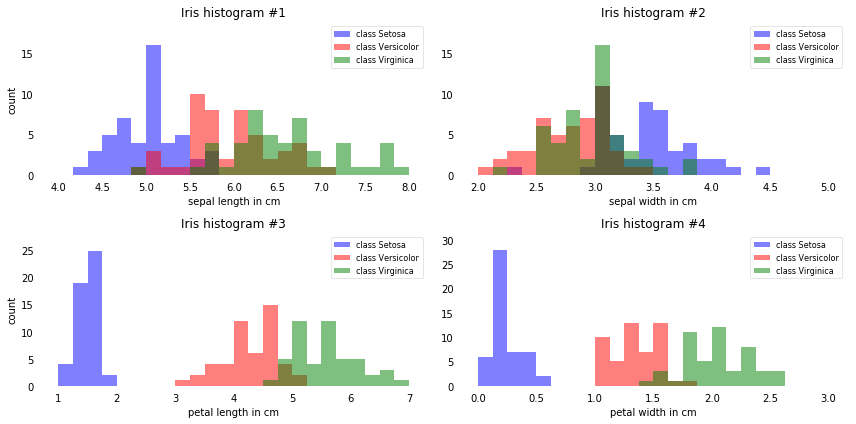

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show();

In [11]:
class LDA():
    """
    Linear Discriminant Analysis 
    
    """
    def __init__(self,k):
        self.k = k
        
    def class_samples(self, X, Y, class_number):
        """
        This method return samples with given class number
        """
        return X[Y == class_number]
    
    def compute_overal_mean(self, X):
        """
        This method compute overal mean off data set (with 0 axis)
        """
        return np.mean(X, axis = 0)
    
    def compute_class_means(self, X, Y):
        """
        Method for computing mean for each class, and each feature
        If you have a n features anc k classes,
        then output off this function will be 
        k*n matrix 
        """
        mean_vectors = np.zeros((self.num_classes, self.num_features))
        for i in range(1,self.num_classes + 1):
            mean_vectors[i-1] = np.mean(self.class_samples(X = X, Y = Y, class_number = i), axis = 0)
        return mean_vectors
    
    def compute_within_class_scatter_matrix_for_one_class(self, X, Y, class_number, one_class_means):
        """
        This method return within class scatter matrix for one class,
        if you have a M samples for class and N features 
        output will be N*N matrix
        Don't Forget reshape rows and means to vectors 
        """
        samples = self.class_samples(X = X, Y = Y, class_number = class_number)
        class_sc_mat = np.zeros((self.num_features,self.num_features))        
        for row in samples:
            row = row.T.reshape(-1,1)
            one_class_means = one_class_means.T.reshape(-1,1)
            class_sc_mat += (np.dot((row - one_class_means), (row - one_class_means).T))
        return class_sc_mat
        
    def compute_within_class_scatter_matrix(self, X, Y, class_means):
        """
        This method compute within_class_scatter_matrix for all classes
        if you have a M samples for class and N features 
        output will be N*N matrix
        Don't Forget reshape rows and means to vectors 
        """
        with_sc_mat = np.zeros((self.num_features,self.num_features))
        for cl_num in range(1,self.num_classes + 1):
            with_sc_mat += self.compute_within_class_scatter_matrix_for_one_class(X = X,
                                                                                  Y = Y,
                                                                                  class_number=cl_num,
                                                                                  one_class_means=class_means[cl_num-1])
        return with_sc_mat
    
    def compute_between_class_scatter_matrix_for_one_class(self, X, Y, class_number,one_class_means,overal_mean):
        """
        This method return between class scatter matrix for one class,
        if you have a M samples for class and N features 
        output will be N*N matrix
        Don't Forget reshape rows and means to vectors 
        """
        samples = self.class_samples(X = X, Y = Y, class_number = class_number)
        M = samples.shape[0]
        overal_mean = overal_mean.T.reshape(-1,1)
        one_class_means = one_class_means.T.reshape(-1,1)
        return M*np.dot((one_class_means-overal_mean),(one_class_means-overal_mean).T)
    
    def compute_between_class_scatter_matrix(self, X, Y, class_means,overal_mean):
        """
        This method return between class scatter matrix for all class,
        if you have a M samples for class and N features 
        output will be N*N matrix
        Don't Forget reshape rows and means to vectors 
        """
        betw_sc_mat = np.zeros((self.num_features,self.num_features))
        for cl_num in range(1,self.num_classes + 1):
            betw_sc_mat += self.compute_between_class_scatter_matrix_for_one_class(X = X, Y = Y,
                                                                                   class_number=cl_num,
                                                                                   one_class_means=class_means[cl_num-1],
                                                                                   overal_mean=overal_mean)
        return betw_sc_mat
    
    def eig_vals_eig_vecs(self,X_):
        """
        This method compute and return eig. vals and eig. vecs:
        Outpute is tuple
        """
        return np.linalg.eig(X_)
    
    def print_eig_val_eig_vec(self,eig_vals, eig_vecs):
        """
        Not necessary 
        
        Ex`
        Eigenvector 1:
            [[1]
             [2]
             [3]
             [4]]
        Eigenvalue 1: 0.5
        
        Remember eigen values can be complex
        """
        for i in range(len(eig_vals)):
            eigvec_sc = eig_vecs[:,i].T.reshape(-1,1)   
            print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
            print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))
            
    def checking_eig_vals_eig_vecs(self,X_,eig_vals, eig_vecs):
        """
        A quick check that the eigenvector-eigenvalue calculation is correct
    
        """
        for i in range(len(eig_vals)):
            eigv = eig_vecs[:,i].T.reshape(-1,1)
            np.testing.assert_array_almost_equal(X_.dot(eigv),eig_vals[i] * eigv,
                                                 decimal=6, err_msg='', verbose=True)
        print("Eigenvector-eigenvalue calculation is correct")
    
    def return_sorted_eig_val_eig_vec(self,eig_vals,eig_vecs):
        """
        
        Return sorted(by eig. vals) eig vals and eig vecs
        ex`
            eig_vales=[4,3,2]
            eig_vecs=[[3,2],[4,5],[10,2]]
        """
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
        return eig_pairs
    
    def explained_variance(self):
        """
        Not necessary 

        Print explained_variance for each eig. value 
        ex`
        Eigenvalue 1: 54%
        Eigenvalue 2: 36%
        Eigenvalue 3: 10%
        """
        print('Explained Variance Ratio:\n')
        sorted_paires = self.sorted_paires
        eig_vals = [item[0] for item in sorted_paires]
        eigv_sum = sum(eig_vals)
        for i,j in enumerate(sorted_paires):
            print('Eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))
            
    def fit(self, X, Y):
        """
        Fit method.
        This is main LDA alg.
        1.Compute class means
        2.Compute overal mean
        3.Compute within class scatter matrix(S_W)
        4.Compute between class scatter matrix(S_B)
        5.Calculate eig.vals and eig.vecs for (S_W^-1*S_B) matrix 
        6.Sort calculated eig.vals and eig.vecs
        7.Select first k eigenvalues and eigenvectors
        8.Transpose selected vectors
    
        """
        self.num_classes = np.unique(Y).shape[0]
        self.num_features = X.shape[1]
        print("Linear Discriminant analysis")
        class_means = self.compute_class_means(X,y)
        overal_mean = self.compute_overal_mean(X)
        S_W = self.compute_within_class_scatter_matrix(X, y,class_means)
        S_B = self.compute_between_class_scatter_matrix(X,y,class_means,overal_mean)
        X_ = np.linalg.inv(S_W).dot(S_B)
        sorted_pairs = self.return_sorted_eig_val_eig_vec(*self.eig_vals_eig_vecs(X_))[:self.k]
        self.sorted_paires = sorted_pairs
        W = np.zeros((self.num_features,self.k))
        for i in range(self.k):
            W[:,i] = sorted_pairs[i][1].T
        self.W = W
    
    def fit_transform(self, X, Y):
        """
        Fit and transforme data
        return X*W
        """
        self.fit(X, Y)
        X_ = np.dot(X,self.W)
        return X_

In [12]:
lda = LDA(2)
X_tr = lda.fit_transform(X,y)
lda.explained_variance()

Linear Discriminant analysis
Explained Variance Ratio:

Eigenvalue 1: 99.15%
Eigenvalue 2: 0.85%


In [7]:
def Test_lda(X_transformed,X,k):
    #checking shapes
    assert X_transformed.shape == (X.shape[0],k)
    print("shapes is correct")
Test_lda(X_tr,X,2)

shapes is correct


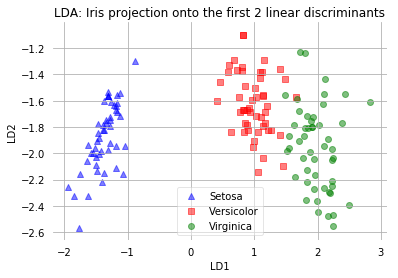

In [8]:
def plot_step_lda(X_tr):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_tr[:,0].real[y == label],
                y=X_tr[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='best', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

    
plot_step_lda(X_tr);